In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools
import time
import sys

from kesi._verbose import (VerboseFFR,
                           LinearMixture,
                           LoadableVerboseFFR, _CrossKernelReconstructor)
from kesi._engine import _LinearKernelSolver
sys.path.append('..')
from FEM.fem_sphere_gaussian import (SomeSphereGaussianSourceFactory3D,
                                     SomeSphereGaussianSourceFactoryOnlyCSD)
from _common_new import altitude_azimuth_mesh

try:
    from joblib import Parallel, delayed
    import multiprocessing
    NUM_CORES = multiprocessing.cpu_count() - 1
    PARALLEL_AVAILABLE = True
except ImportError:
    PARALLEL_AVAILABLE = False

MeasurementManagerBase = VerboseFFR.MeasurementManagerBase

Unable to import from dolfin


In [2]:
class MeasurementManager(MeasurementManagerBase):
    def __init__(self, ELECTRODES, space='potential'):
        self._space = space
        self._ELECTRODES = ELECTRODES
        self.number_of_measurements = len(ELECTRODES)
    def probe(self, field):
        return getattr(field, 
                       self._space)(self._ELECTRODES.X,
                                    self._ELECTRODES.Y,
                                    self._ELECTRODES.Z)

In [3]:
def all_sources(r, altitude, azimuth):
    return [factory(x, y, z)
            for x, y, z in itertools.product(r, altitude, azimuth)]

In [4]:
def calculate_point_error(true_csd, est_csd):
    """
    Calculates normalized error of reconstruction at every point of
    estimation space separetly.

    Parameters
    ----------
    true_csd: numpy array
        Values of true csd at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.

    Returns
    -------
    point_error: numpy array
        Normalized error of reconstruction calculated separetly at every
        point of estimation space.
    """
    true_csd_r = true_csd.reshape(true_csd.size, 1)
    est_csd_r = est_csd.reshape(est_csd.size, 1)
    epsilon = np.linalg.norm(true_csd_r)/np.max(abs(true_csd_r))
    err_r = abs(est_csd_r/(np.linalg.norm(est_csd_r)) -
                true_csd_r/(np.linalg.norm(true_csd_r)))
    err_r *= epsilon
    point_error = err_r.reshape(true_csd.shape)
    return point_error

In [47]:
def calculate_rms(true_csd, est_csd):
    """
    Calculates normalized error of reconstruction.
    Parameters
    ----------
    true_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    rms: float
        Normalized error of reconstruction.
    """
    rms = np.linalg.norm((true_csd - est_csd))/(np.linalg.norm(true_csd))
    return rms

In [48]:
def calculate_rdm(true_csd, est_csd):
    """
    Calculates relative difference measure between reconstructed source and
    ground truth.
    Parameters
    ----------
    true_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    rdm: float
        Relative difference measure.
    """
    epsilon = np.finfo(np.float64).eps
    rdm = np.linalg.norm(est_csd/(np.linalg.norm(est_csd) + epsilon) -
                         true_csd/(np.linalg.norm(true_csd) + epsilon))
    return rdm

In [81]:
def calculate_rdm_point(true_csd, est_csd):
    rdm = abs(est_csd.reshape(est_csd.size, 1)/(np.linalg.norm(est_csd.reshape(est_csd.size, 1))) -
              true_csd.reshape(true_csd.size, 1)/(np.linalg.norm(true_csd.reshape(true_csd.size, 1))))
    rdm *= np.linalg.norm(true_csd.reshape(true_csd.size, 1))/np.max(abs(true_csd.reshape(true_csd.size, 1)))
    return rdm.reshape(true_csd.shape)

In [49]:
def calculate_mag(true_csd, est_csd):
    """
    Calculates magnitude ratio between reconstructed source and ground
    truth.
    Parameters
    ----------
    test_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    mag: float
        Magnitude ratio.
    """
    epsilon = np.finfo(np.float64).eps
    mag = np.linalg.norm(est_csd/(true_csd + epsilon))
    return mag

In [82]:
def calculate_mag_point(true_csd, est_csd):
    epsilon = np.max(abs(true_csd.reshape(true_csd.size, 1)))
    mag = abs(est_csd.reshape(est_csd.size, 1))/(abs(true_csd.reshape(true_csd.size, 1)) + epsilon)
    return mag.reshape(true_csd.shape)

In [5]:
def cross_validate(reconstructor, measurements, regularization_parameters):
    errors = np.zeros(regularization_parameters.size)
    for rp_idx, rp in enumerate(regularization_parameters):
        print('Cross validating regularization parameter :', rp)
        errors[rp_idx] = np.linalg.norm(reconstructor.leave_one_out_errors(measurements, rp))
    err_idx = np.where(errors == np.min(errors))
    cv_rp = regularization_parameters[err_idx][0]
    print('CV_rp :', cv_rp)
    return cv_rp, errors

In [43]:
def make_plot(values, val_type, X, Y, Z, path, idx=15, fig_title=None):
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.set_title(fig_title)
    if val_type == 'csd':
        cmap = cm.bwr
        t_max = np.max(np.abs(values))
        t_min = -t_max
    else:
        cmap = cm.Greys
        t_max = np.max(np.abs(values))#1
        t_min = 0
    levels = np.linspace(t_min, t_max, 65)
    ax.set_aspect('equal')
    im = ax.contourf(X[idx, :, :], Z[idx, :, :], values[:, idx, :], levels=levels, cmap=cmap, alpha=1)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Z (m)')
    ax.set_xticks([X.min(), 0, X.max()])
    ax.set_yticks([Z.min(), 0, Z.max()])
    ticks = np.linspace(t_min, t_max, 3, endpoint=True)
    plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)
    plt.savefig(path + '/' + str(fig_title) +'.png', dpi=300)
    return

In [7]:
def generate_figure(X, Y, Z, values, values_type, IDX, layer, title, save_path=sys.path[0]):
    VALUES = np.zeros(X.shape)  
    for v, i, j, k in zip(values, *np.where(IDX)):  # place values in regular grid
        VALUES[i, j, k] = v
    make_plot(VALUES, values_type, X, Y, Z, save_path, idx=layer, fig_title=title)

In [8]:
start_time = time.time()    
MESHFILE = '/home/mbejtka/Data_Kuba/four_spheres_gaussian_1000_deg_1.npz'
factory = SomeSphereGaussianSourceFactory3D(MESHFILE)
print("Loading data --- %s seconds ---" % (time.time() - start_time))

dst = factory.R[1] - factory.R[0]
sources = [factory(r, altitude, azimuth)
           for altitude, azimuth in altitude_azimuth_mesh(-np.pi/2,
                                                          dst/factory.scalp_radius)
           for r in factory.R]
print('Number of sources: ', len(sources))
print("Sources --- %s seconds ---" % (time.time() - start_time))

Loading data --- 2.543119430541992 seconds ---
Number of sources:  45508
Sources --- 6.691377639770508 seconds ---


In [9]:
# Determine positions of electrodes
theta, phi, r = np.meshgrid(np.linspace(-0.5*np.pi, 0.5*np.pi, 15),
                           np.linspace(0, 2*np.pi, 15),
                           [factory.R.max()])
ELE_X = r*np.cos(theta)*np.cos(phi)
ELE_Y = r*np.cos(theta)*np.sin(phi)
ELE_Z = r*np.sin(theta)
ELECTRODES = pd.DataFrame({'X': ELE_X.flatten(),
                           'Y': ELE_Y.flatten(),
                           'Z': ELE_Z.flatten()})

In [10]:
# Estimating points    
r = factory.scalp_radius
X, Y, Z = np.meshgrid(np.linspace(-r, r, 30),
                      np.linspace(-r, r, 30),
                      np.linspace(-r, r, 30))
IDX = X**2 + Y**2 + Z**2 <=r**2
EST_X = X[IDX]
EST_Y = Y[IDX]
EST_Z = Z[IDX]
EST_POINTS =pd.DataFrame({'X': EST_X.flatten(),
                          'Y': EST_Y.flatten(),
                          'Z': EST_Z.flatten()})

In [11]:
measurement_manager = MeasurementManager(ELECTRODES, space='potential')
measurement_manager_basis = MeasurementManager(EST_POINTS, space='csd')

In [12]:
# Create reconstructor
reconstructor_filename = '../SavedReconstructor_four_spheres_1000_deg_1.npz'
#reconstructor = VerboseFFR(sources, measurement_manager)
#reconstructor.save(reconstructor_filename)
#print("Reconstructor --- %s seconds ---" % (time.time() - start_time))

In [13]:
factoryCSD = SomeSphereGaussianSourceFactoryOnlyCSD(MESHFILE)
dst = factoryCSD.R[1] - factoryCSD.R[0]
sourcesCSD = [factoryCSD(r, altitude, azimuth)
              for altitude, azimuth in altitude_azimuth_mesh(-np.pi/2,
                                                          dst/factory.scalp_radius)
              for r in factoryCSD.R]

In [14]:
loadable_reconstructor = LoadableVerboseFFR(reconstructor_filename, sourcesCSD, measurement_manager)
kernel = loadable_reconstructor.kernel
cross_kernel = loadable_reconstructor.get_kernel_matrix(measurement_manager_basis)
cross_reconstructor = _CrossKernelReconstructor(_LinearKernelSolver(kernel), cross_kernel)

In [15]:
potential = [measurement_manager.probe(source) for source in sources]

In [16]:
rps = np.logspace(-1, -15, 7, base=10.)
src_nr = 0
layer = 15
path = sys.path[0]

In [17]:
true_csd = measurement_manager_basis.probe(sourcesCSD[src_nr])
rp, rp_errors = cross_validate(loadable_reconstructor, potential[0], rps)
est_csd = cross_reconstructor(potential[src_nr], rp)
error = calculate_point_error(true_csd, est_csd)

Cross validating regularization parameter : 0.1
Cross validating regularization parameter : 0.00046415888336127773
Cross validating regularization parameter : 2.1544346900318822e-06
Cross validating regularization parameter : 1e-08
Cross validating regularization parameter : 4.641588833612773e-11
Cross validating regularization parameter : 2.154434690031878e-13
Cross validating regularization parameter : 1e-15
CV_rp : 2.154434690031878e-13


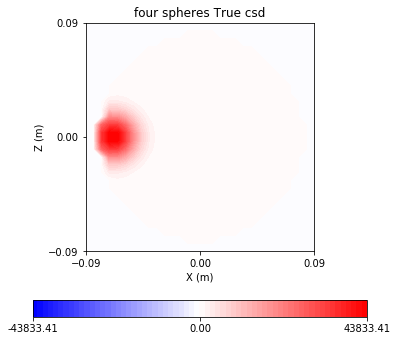

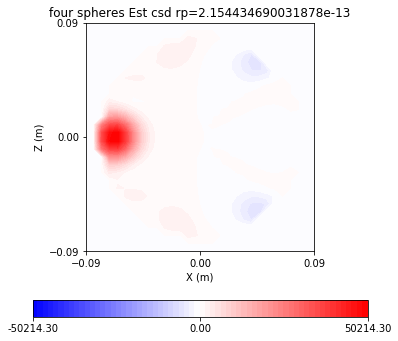

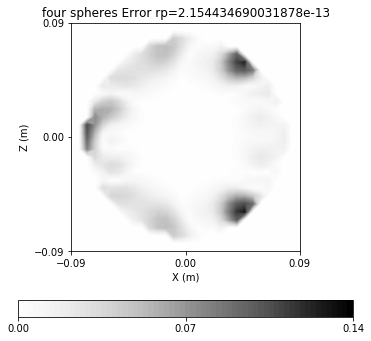

In [18]:
sphere = 'four spheres'
generate_figure(X, Y, Z, true_csd, 'csd', IDX, layer, str(sphere)+' True csd', path)
generate_figure(X, Y, Z, est_csd, 'csd', IDX, layer, str(sphere)+' Est csd rp=' + str(rp), path)
generate_figure(X, Y, Z, error, 'err', IDX, layer, str(sphere)+' Error rp=' + str(rp), path)

125675.74430487474

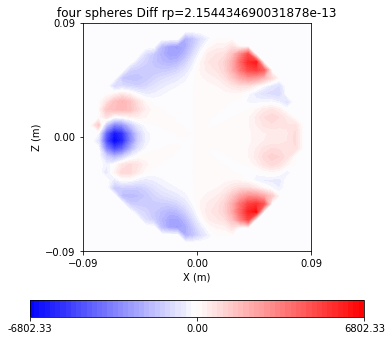

In [19]:
diff = true_csd - est_csd
generate_figure(X, Y, Z, diff, 'csd', IDX, layer, str(sphere)+' Diff rp=' + str(rp))
np.linalg.norm(diff)

In [45]:
def plot_cv_errors(rps, rp_errors, sphere, src_nr, save_path):
    plt.figure(figsize=(6, 4))
    plt.title(sphere)
    plt.plot(rps, rp_errors, '.')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel('Error in potential space')
    plt.savefig(save_path + '/cv_errors ' + sphere + '1000_deg_1 src_'+  str(src_nr) + '.png', dpi=300)

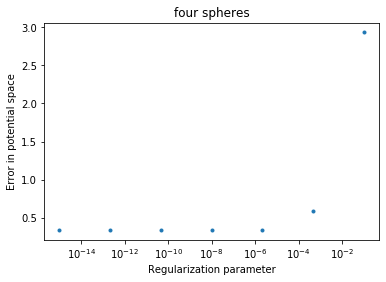

In [21]:
plot_cv_errors(rps, rp_errors, sphere, src_nr, path)

In [22]:
def picard_plot(eigenvalues, eigenvectors, potential, sphere, number, save_path):
    #idx = eigenvalues.argsort()[::-1]
    #eigenvalues = eigenvalues[idx]
    #eigenvectors = eigenvectors[:, idx]
    utb = abs(np.matmul(eigenvectors.T, potential))
    utbs = abs(np.matmul(eigenvectors.T, potential))/eigenvalues
    plt.figure(figsize=(8, 5))
    plt.title('Picard plot')
    plt.plot(eigenvalues, '.', label=r'$\mu^{\frac{1}{2}}$')
    plt.plot(utb, label='$|W^{T}V|$')
    plt.plot(utbs, label=r'$\frac{|W^{T}V|}{\mu^{\frac{1}{2}}}$')
    plt.axvline(x=21, linestyle='--', color='black', label='cut-off')
    plt.yscale('log')
    plt.xlabel('Component number')
    plt.legend(ncol=4)
    plt.savefig(save_path +'/Picard_plot '+str(sphere)+' 1000_pots_' + str(number) + '.png', dpi=300)
    plt.show()

In [23]:
def evd(kernel, regularization_parameter=0):
    eigenvalues, eigenvectors = np.linalg.eigh(kernel + np.identity(kernel.shape[0])
                                               * regularization_parameter)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    return eigenvalues, eigenvectors

In [24]:
eigenvalues, eigenvectors = evd(kernel, regularization_parameter=0)
eigenvalues.shape

(225,)

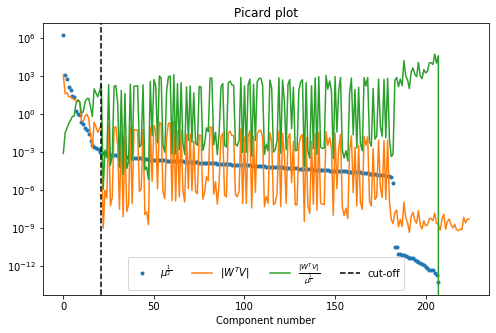

In [25]:
picard_plot(eigenvalues, eigenvectors, potential[src_nr], sphere, src_nr, path)

Cross validating regularization parameter : 1693894.2346368015
Cross validating regularization parameter : 1232.3840249816478
Cross validating regularization parameter : 643.0380902512378
Cross validating regularization parameter : 130.9008743064649
Cross validating regularization parameter : 73.88566599636296
Cross validating regularization parameter : 25.572484987244405
Cross validating regularization parameter : 21.292238837146307
Cross validating regularization parameter : 1.6281943669637067
Cross validating regularization parameter : 0.9330026092502074
Cross validating regularization parameter : 0.8942040666983908
Cross validating regularization parameter : 0.2376298355516971
Cross validating regularization parameter : 0.1782197198494143
Cross validating regularization parameter : 0.0720268073518758
Cross validating regularization parameter : 0.057510054619676836
Cross validating regularization parameter : 0.026693556705947682
Cross validating regularization parameter : 0.00703527

Cross validating regularization parameter : 5.285658080439342e-05
Cross validating regularization parameter : 5.284356545443993e-05
Cross validating regularization parameter : 5.188269713344834e-05
Cross validating regularization parameter : 5.1227046923206805e-05
Cross validating regularization parameter : 4.9300579568354936e-05
Cross validating regularization parameter : 4.8991059743515e-05
Cross validating regularization parameter : 4.723694607511863e-05
Cross validating regularization parameter : 4.653033975330238e-05
Cross validating regularization parameter : 4.5993133270046215e-05
Cross validating regularization parameter : 4.4786142515989096e-05
Cross validating regularization parameter : 4.186478119869966e-05
Cross validating regularization parameter : 4.1660722885305486e-05
Cross validating regularization parameter : 4.107764264624654e-05
Cross validating regularization parameter : 4.064627655499531e-05
Cross validating regularization parameter : 3.8800453627458304e-05
Cross 

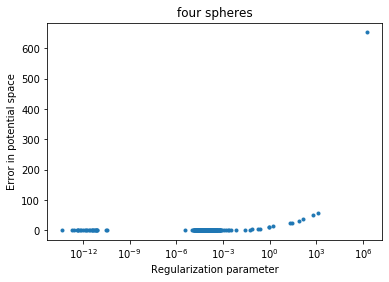

In [26]:
rp_eigenvals = eigenvalues[:]
rp_ev, ev_err = cross_validate(loadable_reconstructor, potential[src_nr], rp_eigenvals)
plot_cv_errors(rp_eigenvals, ev_err, sphere, src_nr, path)

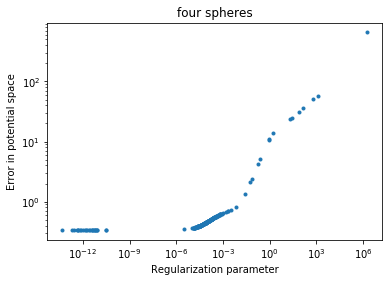

In [46]:
plot_cv_errors(rp_eigenvals, ev_err, sphere, src_nr, path)

In [33]:
index = np.where(ev_err == np.min(ev_err))[0]
rp_eigenvals[index]

array([-5.69132598e-13, -6.92195824e-13, -8.88481146e-13])

In [51]:
rp_eigenvals = eigenvalues[:]
method = 'CV'
rms = np.zeros(len(rp_eigenvals))
rdm = np.zeros(len(rp_eigenvals))
mag = np.zeros(len(rp_eigenvals))
for j, value in enumerate(rp_eigenvals):
    est_csd_ev = cross_reconstructor(potential[src_nr], np.array(value))
    rms[j] = calculate_rms(true_csd, est_csd_ev)
    rdm[j] = calculate_rdm(true_csd, est_csd_ev)
    mag[j] = calculate_mag(true_csd, est_csd_ev)
    #generate_figure(X, Y, Z, est_csd_ev, 'csd', IDX, layer,
     #               str(sphere)+' Est csd '+method+' rp=' + str(value), path)

In [79]:
def plot_global_csd_errors(rps, error, sphere, src_nr, save_path, title):
    plt.figure(figsize=(6, 4))
    plt.title(sphere + title)
    plt.plot(rps, error, '.')
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel('Error in csd space')
    plt.savefig(save_path + '/' + sphere + title + '1000_deg_1 src_'+  str(src_nr) + '.png', dpi=300)

In [66]:
rms.shape

(225,)

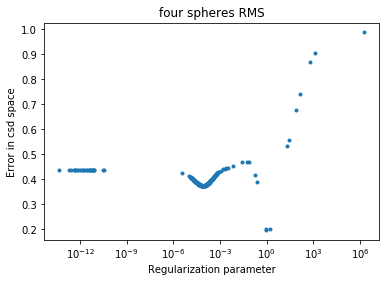

In [70]:
plot_global_csd_errors(rp_eigenvals, rms, sphere, src_nr, path, title=' RMS')

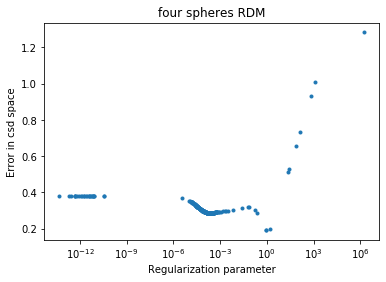

In [71]:
plot_global_csd_errors(rp_eigenvals, rdm, sphere, src_nr, path, title=' RDM')

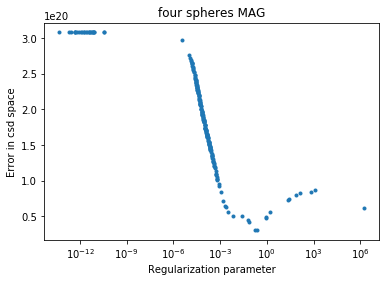

In [80]:
plot_global_csd_errors(rp_eigenvals, mag, sphere, src_nr, path, title=' MAG')

In [77]:
np.min(mag)

3.0435520109926654e+19

In [39]:
np.where((rp_eigenvals>0.89) & (rp_eigenvals<0.95))

(array([8, 9]),)

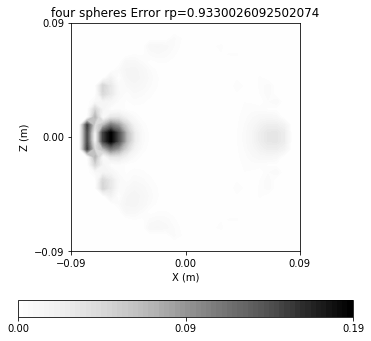

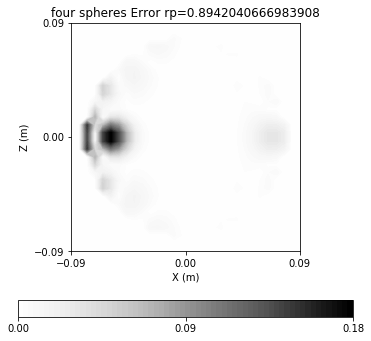

In [44]:
est_csd_8 = cross_reconstructor(potential[src_nr], np.array(rp_eigenvals[8]))
est_csd_9 = cross_reconstructor(potential[src_nr], np.array(rp_eigenvals[9]))
error_ev_8 = calculate_point_error(true_csd, est_csd_8)
error_ev_9 = calculate_point_error(true_csd, est_csd_9)
generate_figure(X, Y, Z, error_ev_8, 'err', IDX, layer, str(sphere)+' Error rp=' + str(rp_eigenvals[8]), path)
generate_figure(X, Y, Z, error_ev_9, 'err', IDX, layer, str(sphere)+' Error rp=' + str(rp_eigenvals[9]), path)

-5.691325983027808e-13


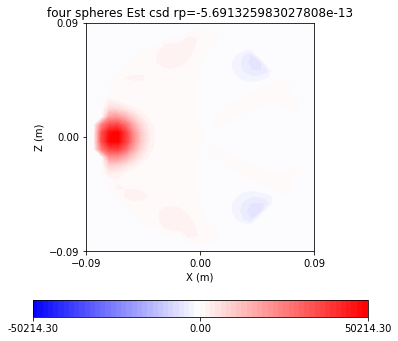

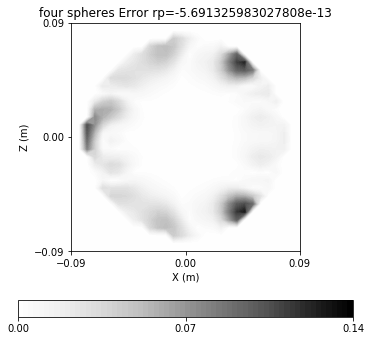

In [27]:
print(rp_ev)
est_csd_ev = cross_reconstructor(potential[src_nr], rp_ev)
error_ev = calculate_point_error(true_csd, est_csd_ev)
generate_figure(X, Y, Z, est_csd_ev, 'csd', IDX, layer, str(sphere)+' Est csd rp=' + str(rp_ev), path)
generate_figure(X, Y, Z, error_ev, 'err', IDX, layer, str(sphere)+' Error rp=' + str(rp_ev), path)

In [28]:
np.all(est_csd == est_csd_ev)

False

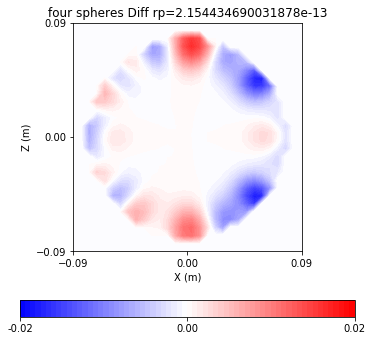

In [29]:
diff = est_csd - est_csd_ev
generate_figure(X, Y, Z, diff, 'csd', IDX, layer, str(sphere)+' Diff rp=' + str(rp))

In [102]:
def picard_plot_log(eigenvalues, eigenvectors, potential, sphere, number, save_path):
    #idx = eigenvalues.argsort()[::-1]
    #eigenvalues = eigenvalues[idx]
    #eigenvectors = eigenvectors[:, idx]
    utb = abs(np.matmul(eigenvectors.T, potential))
    utbs = abs(np.matmul(eigenvectors.T, potential))/eigenvalues
    plt.figure(figsize=(8, 5))
    plt.title('Picard plot')
    plt.plot(eigenvalues, eigenvalues, '.', label=r'$\mu^{\frac{1}{2}}$')
    plt.plot(eigenvalues, utb, label='$|W^{T}V|$')
    plt.plot(eigenvalues, utbs, label=r'$\frac{|W^{T}V|}{\mu^{\frac{1}{2}}}$')
    #plt.axvline(x=21, linestyle='--', color='black', label='cut-off')
    plt.yscale('log')
    plt.xlabel('Eigenvalues')
    plt.xscale('log')
    plt.legend(ncol=4)
    plt.savefig(save_path +'/Picard_plot_log '+str(sphere)+' 1000_pots_' + str(number) + '.png', dpi=300)
    plt.show()

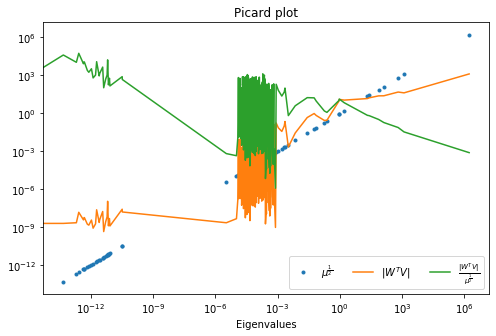

In [104]:
picard_plot_log(eigenvalues, eigenvectors, potential[src_nr], sphere, src_nr, path)

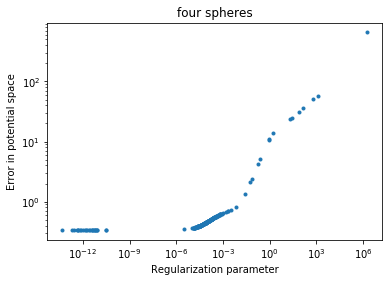

In [105]:
plot_cv_errors(rp_eigenvals, ev_err, sphere, src_nr, path)

In [ ]:
plt.figure()
ax = plt.subplot(221)
